In [2]:
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from collections import Counter
import glob

In [2]:
truth = pd.read_csv("data/allele.deltas.txt", sep='\t')
props = {"HG00438": 0.5 / 100,
         "HG002":   2 / 100,
         "HG02257": 2 / 100,
         "HG02486": 2 / 100,
         "HG02622": 10 / 100,
         "HG005":   83.5 / 100}
percents = []
names = []
for i in truth.columns[3:]:
    percents.append(props[i.split('.')[0]] / 2)
    names.append(i)
percents = pd.Series(percents, index=names)    

truth.set_index(['chrom', 'start', 'end'], inplace=True)
samples = list(truth.columns)

In [9]:

def combine_and_average(numbers, delta=5):
    """
    Numbers that are within delta are combined and averaged
    returns a dictionary of original value mapped to its new average bin
    """
    combined = {}
    current_group = [numbers[0]]

    for num in numbers[1:]:
        if abs(num - current_group[-1]) <= delta:
            current_group.append(num)
        else:
            avg = sum(current_group) / len(current_group)
            for n in current_group:
                combined[n] = avg
            current_group = [num]

    avg = sum(current_group) / len(current_group)
    for n in current_group:
        combined[n] = avg
    
    return combined

def match_reads_to_haplotypes(data):
    rows = []
    for _, row in full_data.iterrows():
        observed = Counter(row['data'][2])

        expected_unaltered = Counter()
        for size, percent in zip(row[samples].values, percents[samples]):
            expected_unaltered[size] += percent

        expected = Counter()
        expected_cnt = Counter()
        vals = sorted(list(expected_unaltered.keys()))
        dedup = combine_and_average(vals, delta=2)
        for k, v in dedup.items():
            expected[v] += expected_unaltered[k]
            expected_cnt[v] += 1

        # Dedup the expected -- If they're within 5bp, combine them.
        closest_numbers = dict([(num, min(expected.keys(), key=lambda x: abs(x - num))) for num in observed])

        # Observed mapto Expected
        summed_observed = Counter()
        for o, e in closest_numbers.items():
            summed_observed[e] += observed[o]
        summed_observed

        chrom, start, end = row.name
        tot_cov = row['coverage']
        if tot_cov == 0:
            continue
        for k in expected.keys():
            obs = summed_observed[k]
            rows.append((chrom, start, end, k, 
                         expected_cnt[k], obs, round(obs / tot_cov, 4), 
                         expected[k], row['coverage']))

    measure = pd.DataFrame(rows, 
                           columns=["chrom", "start", "end", 
                                    "expected_len",
                                    "num_collapsed",
                                    "read_count", 
                                    "observed_vaf", 
                                    "expected_vaf", 
                                    'coverage'])

    measure['vaf_bin'] = pd.cut(measure['expected_vaf'], bins=[0, 0.05, 0.3, 0.7, 1], labels=["Ultra-Low", "Low", "Medium", "High"])
    measure['VAF delta'] = measure["observed_vaf"] - measure["expected_vaf"]
    return measure

parts = []
for fn in glob.glob("data/hapmix*tsv"):
    _, tech, _, center = fn.split('/')[1].split('.')[0].split('_')
    out_name = f"data/hapmix.allele_delta.{tech}.{center}.pq"
    print("starting", out_name)
    
    data = pd.read_csv(fn, sep='\t', names=["chrom", "start", "end", "data"])

    data['data'] = data['data'].apply(lambda x: json.loads(x))

    data.set_index(['chrom', 'start', 'end'], inplace=True)
    full_data = truth.join(data, how='left').dropna()

    full_data['coverage'] = full_data['data'].apply(lambda x: x[0])
    full_data['alt_read_coverage'] = full_data['data'].apply(lambda x: len(x[2]))
    full_data['ref_read_coverage'] = full_data['coverage'] - full_data['alt_read_coverage']

    measure = match_reads_to_haplotypes(full_data)
    
    measure.to_parquet(out_name, index=False)
    del(data)
    del(full_data)
    del(measure)


starting data/hapmix.allele_delta.hifi.UW.pq
starting data/hapmix.allele_delta.ontStd.UW.pq
starting data/hapmix.allele_delta.hifi.WashU.pq
starting data/hapmix.allele_delta.hifi.Broad.pq
starting data/hapmix.allele_delta.ontStd.BCM.pq
starting data/hapmix.allele_delta.hifi.BCM.pq


data/hapmix.allele_delta.hifi.BCM.pq
data/hapmix.allele_delta.hifi.Broad.pq
data/hapmix.allele_delta.hifi.UW.pq
data/hapmix.allele_delta.hifi.WashU.pq
data/hapmix.allele_delta.ontStd.BCM.pq
data/hapmix.allele_delta.ontStd.UW.pq


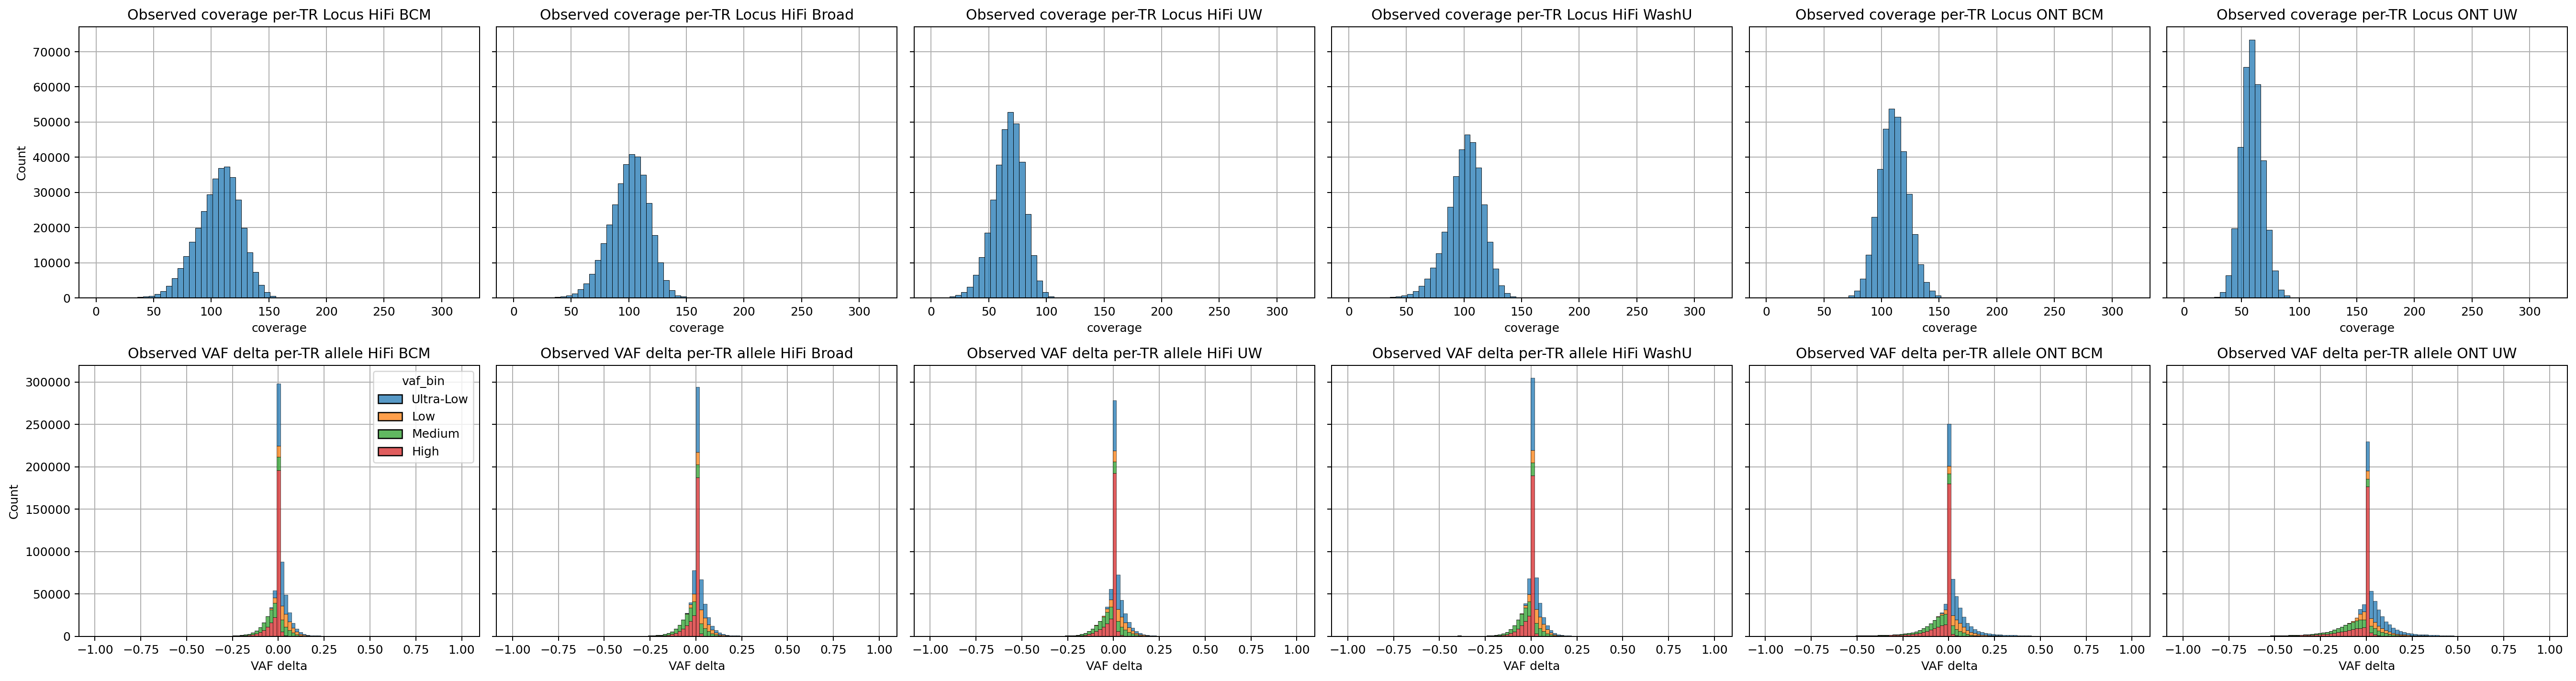

In [3]:
files = ["data/hapmix.allele_delta.hifi.BCM.pq",
         "data/hapmix.allele_delta.hifi.Broad.pq",
         "data/hapmix.allele_delta.hifi.UW.pq",
         "data/hapmix.allele_delta.hifi.WashU.pq",
         "data/hapmix.allele_delta.ontStd.BCM.pq",
         "data/hapmix.allele_delta.ontStd.UW.pq"]
fig, ax = plt.subplots(nrows=2, 
                       ncols=len(files), 
                       figsize=(5 * len(files), 8), 
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )

summary = []
for i, fn in enumerate(files):
    print(fn)
    data = pd.read_parquet(fn)
    _, _, tech, center, _ = fn.split('/')[1].split('.')
    tech = {'hifi': 'HiFi', 'ontStd':"ONT"}[tech]
    unq = data[['chrom', 'start', 'end', 'coverage']].drop_duplicates()
    p = sb.histplot(data=unq, x='coverage', 
                    binwidth=5, 
                    ax=ax[0][i],
                    zorder=2)
    _ = p.set(title=f"Observed coverage per-TR Locus {tech} {center}")
    legend = i == 0    
    p = sb.histplot(data=data[data['read_count'] != 0], 
                    x='VAF delta', hue="vaf_bin", 
                    ax=ax[1][i], 
                    legend = i == 0, 
                    binwidth=0.02,
                    multiple='stack',
                    zorder=2)
    _ = p.set(title=f"Observed VAF delta per-TR allele {tech} {center}")
    ax[0][i].grid(zorder=1)
    ax[1][i].grid(zorder=1)
    if True: # Turn this false if you want to plot fast but miss out on the summary
        row = [(data['read_count'] == 0).sum(),  # Unsupported
               len(data[['chrom', 'start', 'end']].drop_duplicates()),
               len(data),
               unq['coverage'].mean(),
               unq['coverage'].std(),
              ]
        cols = ['No Support', "Num Loci", "Num Alleles", 'Mean Coverage', "STD Coverage"]
        for min_cov in [1, 3, 5]:
            view = data[data['read_count'] >= min_cov]
            total = len(view)
            vaf_delta_mse = (view['VAF delta'] ** 2).sum() / total
            vaf_delta_std = view['VAF delta'].std()
            vaf_delta_mean = view['VAF delta'].mean()
            row.extend([total, vaf_delta_mse, vaf_delta_std, vaf_delta_mean])
            cols.extend([f"num_loci_{min_cov}x", 
                         f"∆MSE_{min_cov}x", 
                         f"∆STD_{min_cov}x",
                         f"∆MU_{min_cov}x"])
        tmp = pd.Series(row, index=cols)
        tmp['tech'] = tech
        tmp['center'] = center
        summary.append(tmp)

plt.tight_layout()
plt.show()

In [4]:
full_summary = pd.concat(summary, axis=1).T

In [11]:
def scaled_fontsize(base_size, fig_width, reference_width=6.4, min_size=7):
    """
    Scales the base font size proportionally to figure width,
    but enforces a minimum font size.
    
    base_size: font size for reference_width (in inches)
    fig_width: actual figure width
    """
    scale = fig_width / reference_width
    return max(min_size, base_size * scale)


fig_width = 6.5
font_size = scaled_fontsize(base_size=8, fig_width=fig_width, min_size=7)

plt.rcParams.update({
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size * 0.9,
    "ytick.labelsize": font_size * 0.9,
    "legend.fontsize": font_size * 0.9,
})

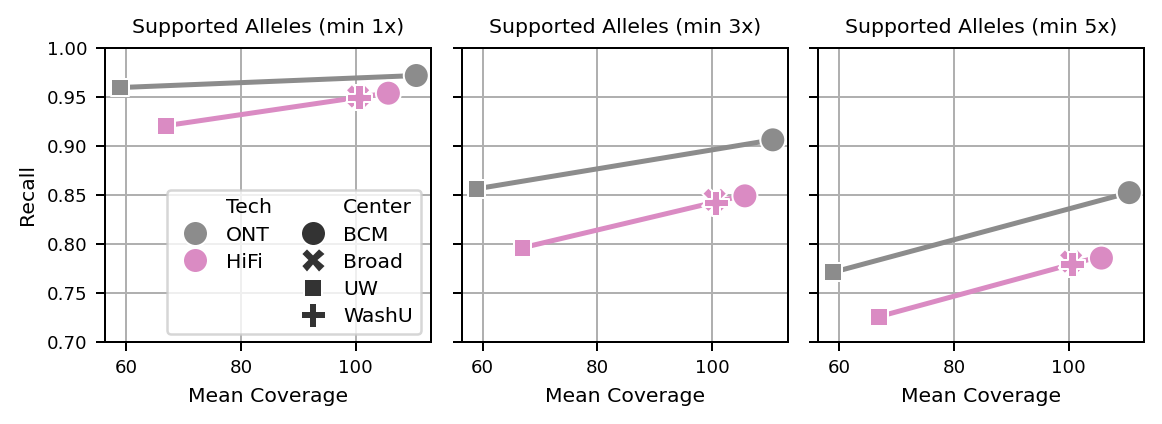

In [57]:
x = [1, 3, 5]
fig, ax = plt.subplots(nrows=1, 
                       ncols=len(x), 
                       #figsize=(5 * len(x), 5), 
                       figsize=(6.5, 2.4),
                       squeeze=False,
                       sharex='row',
                       sharey='row',
                       dpi=180,
                      )
palette = sb.color_palette('deep', n_colors=8) 


for idx, i in enumerate(x):
    ax_sub = ax[0][idx]

    # Scatterplot with hue + style
    sb.scatterplot(
        data=full_summary,
        x="Mean Coverage",
        y=(full_summary[f"num_loci_{i}x"].astype(float) / full_summary['Num Alleles']).values,
        hue='tech',
        style='center',
        ax=ax_sub,
        legend = idx == 0,
        s=100, zorder=3,
        palette=palette[-2:]
        
    )

    # Add regplot manually per 'tech'
    for color, tech_name in enumerate(['HiFi', 'ONT']):
        df_tech = full_summary[full_summary['tech'] == tech_name]
        sb.regplot(
            #data=df_tech,
            x=df_tech["Mean Coverage"].astype(float),
            y=(df_tech[f"num_loci_{i}x"].astype(float) / df_tech['Num Alleles']).values,
            scatter=False,
            ax=ax_sub,
            label=f"{tech_name} trend",  # Optional: avoid duplicate legend
            ci=None,
            line_kws={"lw": 2, "zorder": 2},
            color=palette[-2 + color],
        )

    ax_sub.grid(zorder=1)
    ax_sub.set(
        title=f"Supported Alleles (min {i}x)",
        ylabel="Recall",
        ylim=(0.70, 1.0),
    )


from matplotlib.lines import Line2D

# Extract all handles + labels
handles, labels = ax[0][0].get_legend_handles_labels()

# Classify entries
tech_labels = ['HiFi', 'ONT']
center_labels = sorted(set(full_summary['center']))

tech_items = [(h, l) for h, l in zip(handles, labels) if l in tech_labels]
center_items = [(h, l) for h, l in zip(handles, labels) if l in center_labels]

# Pad shorter column
max_len = max(len(tech_items), len(center_items))
tech_items += [(Line2D([], [], linestyle='None'), '')] * (max_len - len(tech_items))
center_items += [(Line2D([], [], linestyle='None'), '')] * (max_len - len(center_items))

# Combine into interleaved list
combined_handles = []
combined_labels = []

# Add headers
combined_handles += [Line2D([], [], linestyle='None'), Line2D([], [], linestyle='None')]
#combined_labels += ['tech', 'center']

for (h1, l1), (h2, l2) in zip(tech_items, center_items):
    combined_handles += [h1, h2]
    combined_labels += [l1, l2]

combined_labels = ['Tech', 'ONT', 'HiFi', '', '', 'Center', 'BCM', 'Broad', 'UW', 'WashU']

combined_handles = [combined_handles[0],
                    combined_handles[4],
                    combined_handles[2],
                    combined_handles[0],
                    combined_handles[0],
                    combined_handles[0],
                    combined_handles[3],
                    combined_handles[5],
                    combined_handles[7],
                    combined_handles[9]]

# Now place the legend inside ax[0][0]
legend = ax[0][0].legend(
    handles=combined_handles,
    labels=combined_labels,
    ncol=2,
    loc='upper right',
    bbox_to_anchor=(1, 0.55),  # fine-tune as needed
    bbox_transform=ax[0][0].transAxes,
    frameon=True,
    handletextpad=0.5,
    columnspacing=1,
    labelspacing=0.4,
    fontsize=scaled_fontsize(8, 6.5),
)


plt.tight_layout()
plt.show()


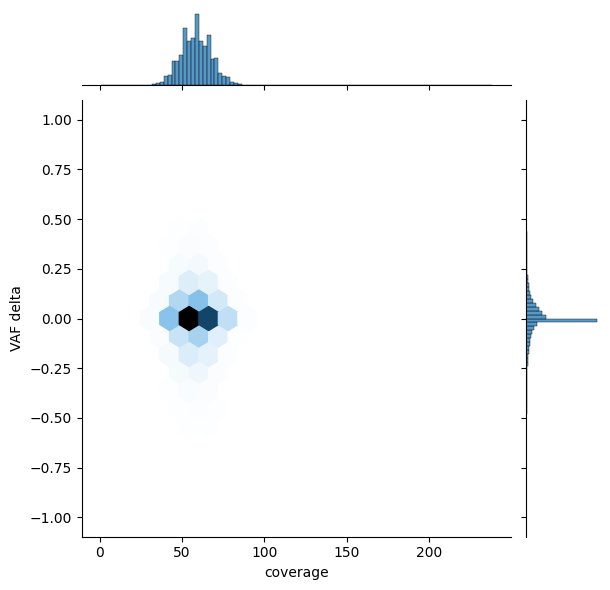

In [14]:
p = sb.jointplot(data=data, x="coverage", kind='hex', y="VAF delta",
                joint_kws=dict(gridsize=20),
                marginal_kws=dict(bins=100))

In [61]:
for i in [1, 3, 5]:
    print(i, pearsonr(full_summary[f"Recall{i}"], full_summary["Mean Coverage"]))
    

1 PearsonRResult(statistic=0.47550696655553776, pvalue=0.34049724734873266)
3 PearsonRResult(statistic=0.5331223320049688, pvalue=0.2760783622235144)
5 PearsonRResult(statistic=0.69976794568566, pvalue=0.12167757808588715)


In [55]:
data['covbin'] = pd.cut(data['coverage'], bins=40)
rs = []
for i, d in data.groupby('covbin'):
    rs.append([i, (d['read_count'] >= 3).sum(), len(d)])
x = pd.DataFrame(rs, columns=['covbin', 'tp', 'count'])
x['recall'] = x['tp'] / x['count']

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_5620/3150223842.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, d in data.groupby('covbin'):


I wanted to do a Multiple Regression, but the 6 observations is too small.

In [31]:
full_summary['Mean_Coverage'] = full_summary['Mean Coverage']
full_summary['Technology'] = full_summary['tech'].astype('category')
full_summary['Recall1'] = pd.to_numeric(full_summary['Recall1'], errors='raise')


In [32]:
import statsmodels.formula.api as smf

model = smf.ols("Recall1 ~ Mean_Coverage + Technology", data=full_summary).fit()
model.summary()

/Users/english/py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/english/py/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/english/py/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1765: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/english/py/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1687: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Recall1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Jul 2025   Prob (F-statistic):                nan
Time:                        22:00:38   Log-Likelihood:                 206.29
No. Observations:                   6   AIC:                            -400.6
Df Residuals:                       0   BIC:                            -401.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.7888        inf          0        nan         nan         nan
Mean_Coverage[T.66.92233368966367]      0.1316        inf          0        nan         nan         nan
Mean_Coverage[T.100.41474818136697]     0.1615        inf          0        nan         nan         nan
Mean_Coverage[T.100.67341832374474]     0.1602        inf          0        nan         nan         nan
Mean_Coverage[T.105.68504274633844]     0.1649        inf          0        nan         nan         nan
Mean_Coverage[T.110.54445795303708]     0.0123        inf          0        nan         nan         nan
Technology[T.ONT]                       0.1706        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.538
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.629
Skew:                           0.466   Prob(JB):                        0.730
Kurtosis:                       1.717   Cond. No.                         4.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The input rank is higher than the number of observations.
"""

In [16]:
import statsmodels.api as sm

cols = []

for i in [1, 3, 5]:
    name = f"Recall{i}"
    full_summary[name] = full_summary[f"num_loci_{i}x"].astype(float) / full_summary['Num Alleles']
    cols.append(name)
    
X = full_summary[['Mean Coverage']].astype(float)
X = sm.add_constant(X)  # Adds intercept
Ys = full_summary[cols].astype(float)

# Fit a separate regression for each Recall measure
models = {col: sm.OLS(Ys[col], X).fit() for col in Ys.columns}

for name, model in models.items():
    print(f"\n{name} regression:")
    print(model.summary())


Recall1 regression:
                            OLS Regression Results                            
Dep. Variable:                Recall1   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1.169
Date:                Thu, 10 Jul 2025   Prob (F-statistic):              0.340
Time:                        21:55:00   Log-Likelihood:                 17.246
No. Observations:                   6   AIC:                            -30.49
Df Residuals:                       4   BIC:                            -30.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9173 

/Users/english/py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/english/py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/english/py/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [165]:
full_summary['Recall'] = full_summary[f"num_loci_1x"].astype(float) / full_summary['Num Alleles']
pearsonr(full_summary['Mean Coverage'], full_summary['Recall'])

PearsonRResult(statistic=0.47550696655553776, pvalue=0.34049724734873266)

In [88]:
x = full_summary[['∆MU_1x', '∆STD_1x']].mean()
x

∆MU_1x     0.000709
∆STD_1x    0.090581
dtype: object

In [89]:
(full_summary[[f'num_loci_{i}x' for i in [1, 3,5]]] / len(data)).mean()

num_loci_1x    0.950711
num_loci_3x    0.848659
num_loci_5x    0.782206
dtype: object

PearsonRResult(statistic=0.9594680488930863, pvalue=0.0)
0.007576570622332692


count    21323.000000
mean         0.002763
std          0.087002
min         -0.863100
25%         -0.012600
50%          0.007500
75%          0.029800
max          0.900000
Name: VAF delta, dtype: float64

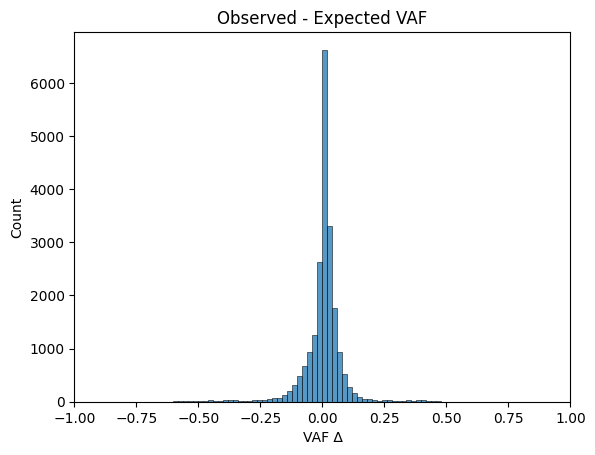

In [62]:
view = measure[(measure['read_count'] != 0) 
              & (measure['expected_len'].abs() >= 5)]
p = sb.histplot(data=view, x="VAF delta", binwidth=0.02)
p.set(title="Observed - Expected VAF", xlabel="VAF ∆", xlim=(-1,1))

print(pearsonr(view['observed_vaf'], view['expected_vaf']))
MSE = ((view['expected_vaf'] - view['observed_vaf']) ** 2).sum()  / len(view)
print(MSE)
view['VAF delta'].describe()

In [92]:
mosaic = pd.read_csv("/Users/english/code/SMaHT_MIMS/callers/severus/bench_hapmix_hifi_GCC_BCM_calls_clean/mosaic.summary.txt", sep='\t')

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_2045/3519708749.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  mosaic = pd.read_csv("/Users/english/code/SMaHT_MIMS/callers/severus/bench_hapmix_hifi_GCC_BCM_calls_clean/mosaic.summary.txt", sep='\t')


In [94]:
import truvari


In [96]:
truvari.performance_metrics(**mosaic['state'].value_counts())

(0.9372990991706021, 0.4816414686825054, 0.6363087009378571)

In [111]:
mosaic['state'].value_counts()

state
fn        25200
tp        23619
tpbase    23415
fp         1580
Name: count, dtype: int64

In [105]:
base = mosaic['state'].isin(['tpbase', 'fn']) & (mosaic['expected_vaf'] < 0.3)
all_comp = mosaic['state'].isin(['tp', 'fp'])
comp = ~mosaic['state'].isin(['tpbase', 'fn']) & (mosaic['predicted_vaf'] < 0.3)

In [108]:
base = mosaic[base]
all_comp = mosaic[all_comp]

In [145]:
all_base = mosaic[mosaic['state'].isin(['tpbase', 'fn'])]

In [139]:
ac_bcnt = all_comp['base_id'].value_counts()
ac_ccnt = all_comp['comp_id'].value_counts()

In [147]:
all_base[all_base['base_id'] == 29962.1]

,svtype,svlen,szbin,TRF,NumNeighbors,NeighId,expected_vaf,predicted_vaf,state,hash,base_id,comp_id,expected_vaf_bin,predicted_vaf_bin,matching_vaf_bin,vaf-delta
11415,DEL,1124,"[1k,2.5k)",True,1.0,29025.0,0.4475,0.89,tpbase,0f584ee3bb21d68a8682626d6bbc527cde656802,29962.1,29962.1,Medium,High,False,0.4425


In [142]:
all_comp[all_comp['base_id'] == 29962.1]

,svtype,svlen,szbin,TRF,NumNeighbors,NeighId,expected_vaf,predicted_vaf,state,hash,base_id,comp_id,expected_vaf_bin,predicted_vaf_bin,matching_vaf_bin,vaf-delta
60870,DEL,1125,"[1k,2.5k)",True,1.0,NaN,0.4475,0.30,tp,357fbf73288d94b8817c3dd51777a1caa042803e,29962.1,29962.1,Medium,Medium,True,-0.1475
60871,DEL,1125,"[1k,2.5k)",True,1.0,NaN,0.4475,0.10,tp,9ccf72e95e205723a640c1ca1efcc1d9c7d49177,29962.1,29962.2,Medium,Low,False,-0.3475
60872,DEL,1125,"[1k,2.5k)",True,1.0,NaN,0.4475,0.17,tp,db2fc18a48b8c671cca408e711adc9890d4440f8,29962.1,29962.3,Medium,Low,False,-0.2775
60873,DEL,1125,"[1k,2.5k)",True,1.0,NaN,0.4475,0.09,tp,fcc306cc8fa84d2409f63e2e25ec2fd57982a322,29962.1,29962.4,Medium,Low,False,-0.3575
60874,DEL,1124,"[1k,2.5k)",True,1.0,NaN,0.4475,0.23,tp,b931b6f92a442fe445588e21bf9a0d9dda7b5891,29962.1,29962.5,Medium,Low,False,-0.2175


In [135]:
all_comp[all_comp['comp_id'].isin(base['comp_id'])]['state'].value_counts()

state
tp    14172
fp      781
Name: count, dtype: int64

In [136]:
all_comp[all_comp['base_id'].isin(base['base_id'])]['state'].value_counts()

state
tp    10977
fp      883
Name: count, dtype: int64

In [138]:
base[base['comp_id'].isin(all_comp['comp_id'])]['state'].value_counts()

state
fn        12667
tpbase    10965
Name: count, dtype: int64

In [137]:
base[base['base_id'].isin(all_comp['base_id'])]['state'].value_counts()

state
tpbase    10960
fn          756
Name: count, dtype: int64

In [112]:
a = base['state'].value_counts()
b = all_comp['state'].value_counts()
tmp = pd.concat([a, b])
truvari.performance_metrics(**tmp)

(0.9372990991706021, 0.3195116265516639, 0.47656811580646535)

In [120]:
all_comp[all_comp['comp_id'].isin(base['base_id'])]['state'].value_counts()

state
tp    10976
fp      822
Name: count, dtype: int64

In [119]:
base[base['comp_id'].isin(all_comp['base_id'])]['state'].value_counts()

state
fn        14561
tpbase     7935
Name: count, dtype: int64

In [114]:
base['base_id'].isin(all_comp['base_id']).mean()

0.34139518619966197

In [101]:
exclusive_recall_subset = mosaic[(mosaic['expected_vaf'] < 0.30)]
truvari.performance_metrics(**exclusive_recall_subset['state'].value_counts(), fp=0)

(1.0, 0.3195116265516639, 0.48428770178654246)

In [103]:
len(exclusive_recall_subset), len(recall_subset)

(44079, 48687)

In [115]:
recall_subset = mosaic[(mosaic['predicted_vaf'] < 0.30)
                     | (mosaic['expected_vaf'] < 0.30)]
recall_subset

,svtype,svlen,szbin,TRF,NumNeighbors,NeighId,expected_vaf,predicted_vaf,state,hash,base_id,comp_id,expected_vaf_bin,predicted_vaf_bin,matching_vaf_bin,vaf-delta
1,INS,354,"[300,400)",True,3.0,19.0,0.0500,0.10,tpbase,bea5a92dfe7253692b5349418e67534637181dfe,10.1,10.1,Low,Low,True,0.0500
6,DEL,597,"[400,600)",False,0.0,44776.0,0.1000,0.13,tpbase,0837495609fcbf2978b5e8e98122eaf48324d10c,10007.0,10007.0,Low,Low,True,0.0300
8,INS,62,"[50,100)",True,0.0,44789.0,0.0500,0.05,tpbase,c52392c54ed83f2ea6066f0eed0b5268c8318af6,10012.0,10012.0,Low,Low,True,0.0000
9,DEL,71,"[50,100)",True,0.0,44790.0,0.1200,0.13,tpbase,226b10eb5124d54397c284af5bf20fea47ff166a,10013.0,10013.0,Low,Low,True,0.0100
10,DEL,252,"[200,300)",True,8.0,44792.0,0.0600,0.10,tpbase,cb537ac0ed147930371d54d5f5d8d3c7fcaddae8,10014.2,10014.0,Low,Low,True,0.0400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72212,INS,66,"[50,100)",False,0.0,NaN,0.0500,0.07,tp,bcdcc6a12c3d81ac75460eac001e1ee8c644e69b,18391.0,18391.0,Low,Low,True,0.0200
72220,INS,94,"[50,100)",True,10.0,NaN,0.0600,0.08,tp,7f4ed4a1bb98f898a4e5baa32429a0298ac94ff7,18401.5,18401.0,Low,Low,True,0.0200
72223,DEL,357,"[300,400)",True,0.0,NaN,0.0700,0.05,tp,ca89728e2e01ee5b27c8dd27b64ec08c19a9067d,18402.0,18402.0,Low,Low,True,-0.0200
72225,INS,57,"[50,100)",True,1.0,NaN,0.0500,0.09,tp,cf46a851e37ab209981be55f3aa09d0341337767,18407.0,18407.0,Low,Low,True,0.0400


In [99]:
truvari.performance_metrics(**recall_subset['state'].value_counts())

(0.919874558996472, 0.3500779249693866, 0.5071493318237754)

<Axes: xlabel='VAF delta', ylabel='coverage'>

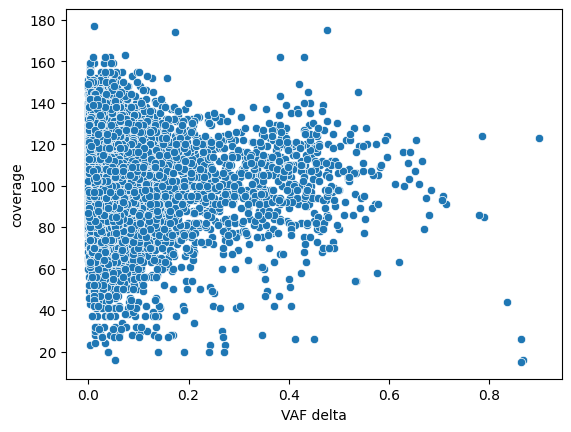

In [63]:
sb.scatterplot(data=view, x=view['VAF delta'].abs(), y='coverage')

In [59]:
pearsonr(view['VAF delta'].abs(), view['coverage'])

PearsonRResult(statistic=-0.018398016587624744, pvalue=0.038401351659267925)

In [50]:
parts = []
mask = (view['expected_vaf'] < 0.30)
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['expected_vaf'].between(0.30, 0.70)
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['expected_vaf'] > 0.70
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

vaf_report = pd.concat(parts, axis=1)
vaf_report.columns = ["Low VAF", "Medium VAF", "High VAF"]

vaf_report.loc[['count', 'mean', '50%', 'std', 'PearsonR', 'MSE']]

,Low VAF,Medium VAF,High VAF
count,8131.000000,2994.000000,1541.000000
mean,0.029866,-0.028806,-0.081944
50%,0.015000,-0.023250,-0.039200
std,0.058225,0.073174,0.127803
PearsonR,0.534601,0.632575,0.635039
MSE,0.004282,0.006182,0.023038


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


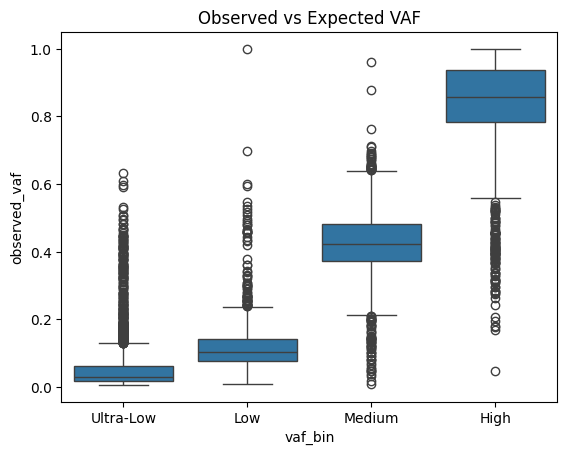

In [ ]:
p = sb.boxplot(data=view, x='vaf_bin', y='observed_vaf')
#sb.kdeplot(data=comp_vars, x="predicted_vaf", y="expected_vaf", hue="vaf_bin")
p.set(title="Observed vs Expected VAF")
plt.legend().remove()

# Max Recall Estimate

In [ ]:
x = measure[(measure['read_count'] == 0) & (measure['expected_len'].abs() >= 50)]
len(x)

327

In [ ]:
len(measure[(measure['expected_len'].abs() >= 50)])

2390

In [ ]:
1 - (len(x) / len(measure[(measure['expected_len'].abs() >= 50)]))

0.8631799163179916

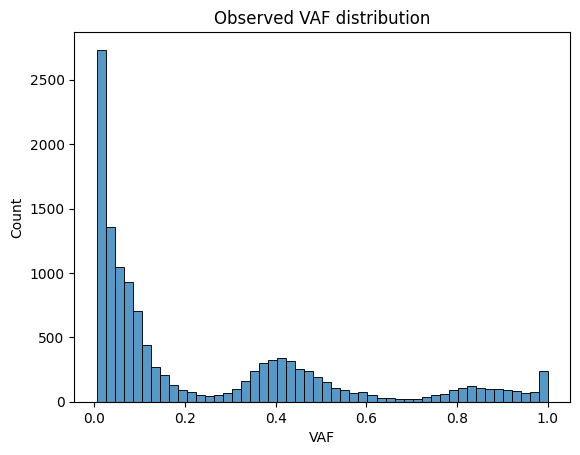

In [57]:
p = sb.histplot(data=view, x="observed_vaf", binwidth=0.02)
_ = p.set(title="Observed VAF distribution", xlabel="VAF")

In [20]:
subset = measure[(measure['expected_len'].abs() >= 50)]
low = (subset['expected_vaf'] < 0.30)
medium = subset['expected_vaf'].between(0.30, 0.70)
high = subset['expected_vaf'] > 0.70

def foo(x):
    missing = (x['read_count'] == 0).sum()
    total = len(x)
    tp = total - missing
    return [tp, missing, total, tp/total]

r = pd.DataFrame([foo(subset[x]) for x in [low, medium, high]], columns=['TP', 'FN', 'total', 'recall'])
r['VAF Bin'] = ['Low', 'Medium', 'High']
r

,TP,FN,total,recall,VAF Bin
0,27611,8609,36220,0.762314,Low
1,10733,37,10770,0.996565,Medium
2,3682,6,3688,0.998373,High


In [16]:
measure

,chrom,start,end,expected_len,read_count,observed_vaf,expected_vaf,vaf_bin,VAF delta
0,chr1,840404,840466,0.00,90,0.9184,0.9900,High,-0.0716
1,chr1,839177,839680,-42.00,95,0.9794,0.9275,High,0.0519
2,chr1,839177,839680,0.00,2,0.0206,0.0625,Low,-0.0419
3,chr1,850622,850687,0.00,19,0.1696,0.9900,High,-0.8204
4,chr1,853415,853930,-49.00,98,0.9703,0.9275,High,0.0428
...,...,...,...,...,...,...,...,...,...
465255,chr9,138107101,138107291,1.75,91,1.0000,0.9800,High,0.0200
465256,chr9,138107726,138108356,-6.50,71,0.8353,0.8575,High,-0.0222
465257,chr9,138107726,138108356,1.00,12,0.1412,0.1325,Low,0.0087
465258,chr9,138099084,138099847,-32.00,1,0.0093,0.0100,Low,-0.0007


In [41]:
washu_pacbio = measure.copy()

In [46]:
bcm_ont = measure.copy()

In [53]:
bcm_pacbio = measure.copy()

In [60]:
bo = bcm_ont[(bcm_ont['expected_len'].abs() >= 50) & (bcm_ont['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])
bp = bcm_pacbio[(bcm_pacbio['expected_len'].abs() >= 50) & (bcm_pacbio['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])
wp = washu_pacbio[(washu_pacbio['expected_len'].abs() >= 50) & (washu_pacbio['read_count'] >= 1)].set_index(['chrom', 'start', 'end', 'expected_len'])

In [61]:
bo.head()

read_count  observed_vaf  expected_vaf  \
chrom start  end    expected_len                                           
chr1  872478 873203 -210.0                41        0.4940        0.4175   
      904387 904830 -98.0                 32        0.3368        0.4200   
                     79.0                  9        0.0947        0.0500   
                     354.0                 7        0.0737        0.0500   
      866379 867217  147.0                92        0.9787        0.9650   

                                 vaf_bin  VAF delta  
chrom start  end    expected_len                     
chr1  872478 873203 -210.0        Medium     0.0765  
      904387 904830 -98.0         Medium    -0.0832  
                     79.0            Low     0.0447  
                     354.0           Low     0.0237  
      866379 867217  147.0          High     0.0137

In [86]:
x = bo.join(bp, lsuffix='_bont', rsuffix='_bpac', how='outer')

In [87]:
x[['read_count_bont', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count_bont,,
False,38087.0,5243.0
True,3939.0,NaN


In [80]:
x = bp.join(wp, lsuffix='_bpac', rsuffix='_wpac', how='outer')

In [83]:
x[['read_count_wpac', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count_wpac,,
False,37340.0,4396.0
True,4686.0,NaN


In [93]:
x = bo.join(wp, lsuffix='_bont', rsuffix='_wpac', how='outer')
x[['read_count_bont', 'read_count_wpac']].isna().value_counts().unstack()

read_count_wpac,False,True
read_count_bont,,
False,37941.0,5389.0
True,3795.0,NaN


In [89]:
y = x.join(wp, how='outer')

In [90]:
both_b = y[(~y['read_count_bont'].isna() == ~y['read_count_bpac'].isna())]

In [91]:
both_b[['read_count', 'read_count_bpac']].isna().value_counts().unstack()

read_count_bpac,False,True
read_count,,
False,35017.0,1472.0
True,3070.0,NaN


In [75]:
both_b['read_count_bpac'].isna().value_counts()

read_count_bpac
False    38087
True      1472
Name: count, dtype: int64

In [77]:
both_b['read_count'].isna().value_counts()

read_count
False    36489
True      3070
Name: count, dtype: int64

# Obs - Exp VAF by Coverage

In [25]:
measure

,chrom,start,end,expected_len,read_count,observed_vaf,expected_vaf,vaf_bin,VAF delta,orig_coverage
0,chr1,840404,840466,0.00,90,0.9184,0.9900,High,-0.0716,97.996516
1,chr1,839177,839680,-42.00,95,0.9794,0.9275,High,0.0519,96.998162
2,chr1,839177,839680,0.00,2,0.0206,0.0625,Low,-0.0419,97.087379
3,chr1,850622,850687,0.00,19,0.1696,0.9900,High,-0.8204,112.028302
4,chr1,853415,853930,-49.00,98,0.9703,0.9275,High,0.0428,100.999691
...,...,...,...,...,...,...,...,...,...,...
465255,chr9,138107101,138107291,1.75,91,1.0000,0.9800,High,0.0200,91.000000
465256,chr9,138107726,138108356,-6.50,71,0.8353,0.8575,High,-0.0222,84.999401
465257,chr9,138107726,138108356,1.00,12,0.1412,0.1325,Low,0.0087,84.985836
465258,chr9,138099084,138099847,-32.00,1,0.0093,0.0100,Low,-0.0007,107.526882


In [83]:
import sys
measure['coverage_bin'] = pd.cut(measure['orig_coverage'], bins=[0, 72, 104, sys.maxsize], labels=["<72", "[72,104)", "≥104"])

/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/english/py/lib/python3.9/site-packages/seaborn/_oldcore.py:1057: Futu

[Text(0.5, 1.0, 'Observed - Expected VAF'), Text(0.5, 0, 'VAF ∆'), (-1.0, 1.0)]

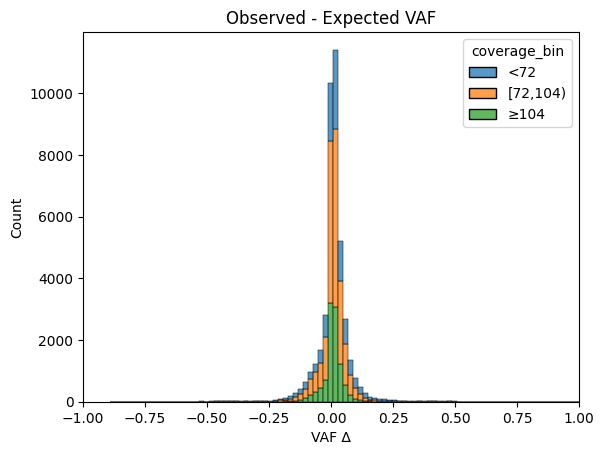

In [84]:
view = measure[(measure['read_count'] != 0) 
              & (measure['expected_len'].abs() >= 50)]
p = sb.histplot(data=view, x="VAF delta", binwidth=0.02, hue='coverage_bin', multiple='stack')
p.set(title="Observed - Expected VAF", xlabel="VAF ∆", xlim=(-1,1))

In [85]:
parts = []
mask = (view['coverage_bin'] == "<72")
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['coverage_bin'] == "[72,104)"
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

mask = view['coverage_bin'] == "≥104"
parts.append((view[mask]['observed_vaf'] - view[mask]['expected_vaf']).describe().to_frame())
parts[-1].loc['PearsonR'] = pearsonr(view[mask]['observed_vaf'], view[mask]['expected_vaf'])[0]
MSE = ((view[mask]['expected_vaf'] - view[mask]['observed_vaf']) ** 2).sum()  / len(view[mask])
parts[-1].loc['MSE'] = MSE

cov_report = pd.concat(parts, axis=1)
cov_report.columns = ["Low Cov", "Medium Cov", "High Cov"]

cov_report.loc[['count', 'mean', '50%', 'std', 'PearsonR', 'MSE']]

,Low Cov,Medium Cov,High Cov
count,10691.000000,20932.000000,10403.000000
mean,0.011488,0.007111,0.004010
50%,0.012200,0.009500,0.006700
std,0.098688,0.061077,0.055039
PearsonR,0.932930,0.976196,0.981030
MSE,0.009870,0.003781,0.003045


In [86]:
measure[(measure['expected_len'].abs() >= 50) 
        & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin'])['VAF delta'].describe()['mean'].unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/583592222.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<72,"[72,104)",≥104
vaf_bin,,,
Low,0.036,0.021,0.017
Medium,-0.020,-0.016,-0.021
High,-0.066,-0.029,-0.036


In [87]:
def pr(x):
    return pearsonr(x['observed_vaf'], x['expected_vaf'])[0]
def mse(x):
    return ((x['expected_vaf'] - x['observed_vaf']) ** 2).sum()  / len(x)

measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin']).apply(mse).unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1669775510.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1669775510.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<72,"[72,104)",≥104
vaf_bin,,,
Low,0.006,0.002,0.002
Medium,0.013,0.006,0.004
High,0.023,0.009,0.011


In [70]:
measure['expected_len'].describe()

count    465260.000000
mean         36.104631
std         900.512764
min      -13021.000000
25%          -4.000000
50%           0.000000
75%           6.500000
max      297863.000000
Name: expected_len, dtype: float64

In [74]:
measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin'])['VAF delta'].describe()['std'].unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/3313651188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<50,"[50,100)",≥100
vaf_bin,,,
Low,0.108,0.045,0.038
Medium,0.145,0.085,0.060
High,0.191,0.098,0.095


In [75]:
measure[(measure['expected_len'].abs() >= 50) 
    & (measure['read_count'] != 0)].groupby(['vaf_bin', 'coverage_bin']).apply(pr).unstack().round(3)

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1710790320.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  measure[(measure['expected_len'].abs() >= 50)
/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_1062/1710790320.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  measure[(measure['expected_len'].abs() >= 50)


coverage_bin,<50,"[50,100)",≥100
vaf_bin,,,
Low,0.297,0.629,0.690
Medium,0.407,0.592,0.636
High,0.397,0.646,0.715
